# Title Clustering with SBERT, HDBSCAN, and UMAP

This notebook clusters text titles from an Excel file using sentence embeddings and visualizes them in 2D space.

## Workflow

1. **Load Titles**  
   Read a column named `titles` from `titles.xlsx`.

2. **Embed Using SBERT (with CUDA)**  
   Use the `all-MiniLM-L12-v2` model from SentenceTransformers to generate embeddings.  
   > ⚠️ **Note:** This script **requires a CUDA-enabled GPU**. It sets `device='cuda'` explicitly and will fail on systems without GPU support.

3. **Normalize Embeddings**  
   Normalize the embeddings before clustering to improve performance.

4. **Cluster with HDBSCAN**  
   Use HDBSCAN to group semantically similar titles. Parameters:
   - `min_cluster_size = 5`
   - `min_samples = 3`
   - Distance metric: `euclidean`

5. **Save Clustered Results**  
   Append cluster labels and normalized embeddings to the original DataFrame and export to `clustered_titles_hdbscan.xlsx`.

6. **Visualize with UMAP**  
   Reduce embeddings to 2D with UMAP for visualization. A color-coded scatter plot shows the clusters.

## Requirements

- `pandas`
- `sentence-transformers`
- `scikit-learn`
- `hdbscan`
- `umap-learn`
- `matplotlib`
- **CUDA-enabled GPU and compatible PyTorch installation**

## Output

- `clustered_titles_hdbscan.xlsx`: Excel file with titles, cluster labels, and embeddings
- A scatter plot of UMAP-reduced embeddings, color-coded by cluster
esponding clusters and embeddings.


Batches:   0%|          | 0/33 [00:00<?, ?it/s]

C:\Users\Vyom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Vyom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN clustering complete, saved to clustered_titles_hdbscan.xlsx


C:\Users\Vyom\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Vyom\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


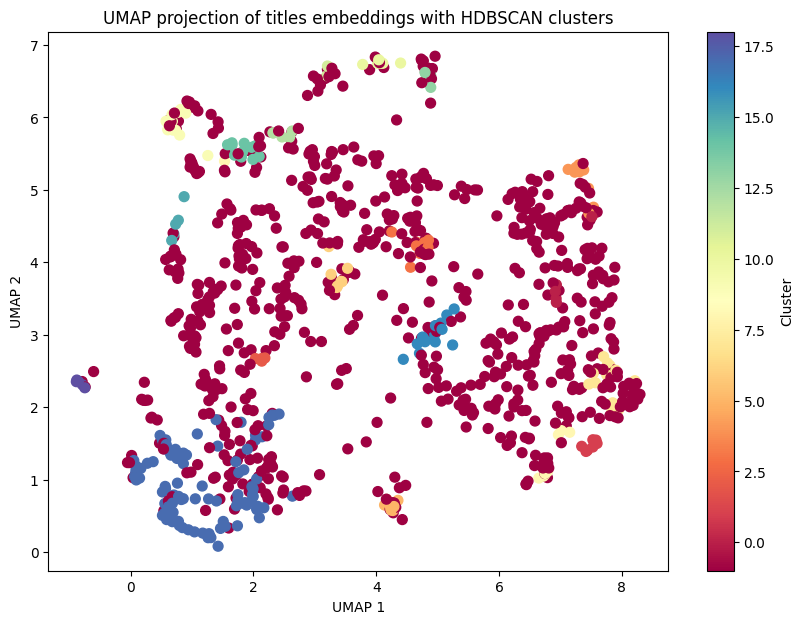

In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import hdbscan
from sklearn.preprocessing import normalize
import umap.umap_ as umap
import matplotlib.pyplot as plt

# Load Excel titles
df = pd.read_excel("titles.xlsx")
titles = df['titles'].astype(str).tolist()

# Load SBERT model and encode titles
model = SentenceTransformer('all-MiniLM-L12-v2', device='cuda')
embeddings = model.encode(titles, show_progress_bar=True)


embeddings_norm = normalize(embeddings)
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,  
    min_samples=3,       
    metric='euclidean',
    cluster_selection_method='eom'
)
clusters = clusterer.fit_predict(embeddings_norm)

df['cluster'] = clusters

embeddings_df = pd.DataFrame(
    embeddings_norm,
    columns=[f'emb_{i}' for i in range(embeddings_norm.shape[1])]
)

# Adding embeddings to df for visualization
df = pd.concat([df, embeddings_df], axis=1)
df.to_excel("clustered_titles_hdbscan.xlsx", index=False)

print("HDBSCAN clustering complete, saved to clustered_titles_hdbscan.xlsx")

# Visualization
embedding_cols = [col for col in df.columns if col.startswith('emb_')]
embeddings = df[embedding_cols].values

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

df['umap_x'] = embedding_2d[:, 0]
df['umap_y'] = embedding_2d[:, 1]

plt.figure(figsize=(10, 7))
scatter = plt.scatter(df['umap_x'], df['umap_y'], c=df['cluster'], cmap='Spectral', s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('UMAP projection of titles embeddings with HDBSCAN clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()


# Token Count per Cluster using BERT Tokenizer

This section calculates the number of BERT tokens required to represent the combined titles in each cluster. This is useful when estimating input size limits for models like BERT, which have a token cap (typically 512 tokens).

## Workflow

1. **Load Clustered Titles**  
   Read the `clustered_titles_hdbscan.xlsx` file, which includes titles and their assigned HDBSCAN clusters.

2. **Group Titles by Cluster**  
   Aggregate titles into lists by their cluster ID.

3. **Initialize BERT Tokenizer**  
   Use the `bert-base-uncased` tokenizer from Hugging Face's Transformers library.

4. **Count Tokens per Cluster**  
   - Concatenate all titles within each cluster into one string.
   - Tokenize the full string using the BERT tokenizer.
   - Count the number of tokens generated.

5. **Print Token Counts**  
   Display the number of tokens needed per cluster for reference.

## Requirements

- `pandas`
- `transformers` (`bert-base-uncased` model)
- `openpyxl` 


In [2]:
import pandas as pd
from transformers import BertTokenizer

df = pd.read_excel("clustered_titles_hdbscan.xlsx")

# Group titles by cluster as lists
grouped_titles = df.groupby('cluster')['titles'].apply(list).to_dict()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def count_tokens(text_list):
    # Join all titles in the cluster
    full_text = " ".join(text_list)
    tokens = tokenizer.tokenize(full_text)
    return len(tokens)

tokens_per_cluster = {cluster: count_tokens(titles) for cluster, titles in grouped_titles.items()}

# Print token counts per cluster
for cluster, token_count in tokens_per_cluster.items():
    print(f"Cluster {cluster}: {token_count} tokens")

Cluster -1: 8951 tokens
Cluster 0: 33 tokens
Cluster 1: 94 tokens
Cluster 2: 61 tokens
Cluster 3: 119 tokens
Cluster 4: 157 tokens
Cluster 5: 73 tokens
Cluster 6: 70 tokens
Cluster 7: 207 tokens
Cluster 8: 127 tokens
Cluster 9: 157 tokens
Cluster 10: 92 tokens
Cluster 11: 52 tokens
Cluster 12: 59 tokens
Cluster 13: 64 tokens
Cluster 14: 208 tokens
Cluster 15: 61 tokens
Cluster 16: 223 tokens
Cluster 17: 1489 tokens
Cluster 18: 95 tokens


# Subclustering HDBSCAN Noise Cluster (-1) with K-Means

The HDBSCAN clustering assigned a large number of titles to the noise cluster `-1`, indicating they didn’t fit well into any dense cluster. However, this group was too large — exceeding the 512-token limit of models like BERT when combined.

To address this, we apply **K-Means clustering** to further divide the `-1` cluster into manageable subclusters.

## Workflow

1. **Load Clustered Data**  
   Read the output from the previous HDBSCAN run (`clustered_titles_hdbscan.xlsx`).

2. **Extract Noise Cluster (-1)**  
   Filter all rows where the HDBSCAN cluster is `-1`.

3. **Apply K-Means to Noise Cluster**  
   Use `KMeans` with `n_clusters=6` to partition the noise cluster into subclusters.  
   - Input: 384-dimensional SBERT embeddings
   - `random_state=42` ensures reproducibility

4. **Save and Inspect Results**  
   - A new column `subcluster` is added for these K-Means labels.
   - Save the results to `cluster_minus1_with_subclusters.xlsx`.
   - Print the top few rows to verify the assignments.

## Why This Step is Necessary

BERT models have a maximum input size of **512 tokens**, and the noise cluster `-1` contained **too many titles** to fit within that limit. By subclustering, we ensure each group stays within manageable token bounds for further processing or summarization.

## Requirements

- `pandas`
- `scikit-learn`
- `openpyxl`

In [13]:
import pandas as pd
from sklearn.cluster import KMeans

df = pd.read_excel('clustered_titles_hdbscan.xlsx')  # Replace with your actual filename

# Filter only cluster -1 rows
cluster_minus1_df = df[df['cluster'] == -1]

embedding_cols = [f'emb_{i}' for i in range(384)]
X = cluster_minus1_df[embedding_cols].values
kmeans = KMeans(n_clusters=24, random_state=42)
kmeans.fit(X)

# Adding new cluster labels as a new column
cluster_minus1_df['subcluster'] = kmeans.labels_

print(cluster_minus1_df[['titles', 'cluster', 'subcluster']].head())
cluster_minus1_df.to_excel('cluster_minus1_with_subclusters.xlsx', index=False)


C:\Users\Vyom\AppData\Local\Temp\ipykernel_6432\1252570946.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_minus1_df['subcluster'] = kmeans.labels_


                                              titles  cluster  subcluster
0                   DONT Wake Your Baby To Feed Them       -1           9
1                       Is the Salt You Eat Healthy?       -1           2
2  Expert Warns ! Parents Are Making THIS Crucial...       -1          11
3  Raising Learners: Understanding The Role Of Sc...       -1          12
4  Lifestyle Fashion Influencer At 40 To Perimeno...       -1          13


# Token Count per Subcluster using BERT Tokenizer

In [14]:
import pandas as pd
from transformers import BertTokenizer


df = pd.read_excel("cluster_minus1_with_subclusters.xlsx")

# Group titles by cluster as lists
grouped_titles = df.groupby('subcluster')['titles'].apply(list).to_dict()

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def count_tokens(text_list):
    # Join all titles in the cluster
    full_text = " ".join(text_list)
    tokens = tokenizer.tokenize(full_text)
    return len(tokens)

tokens_per_cluster = {cluster: count_tokens(titles) for cluster, titles in grouped_titles.items()}

# Print token counts per cluster
for cluster, token_count in tokens_per_cluster.items():
    print(f"Cluster {cluster}: {token_count} tokens")

Cluster 0: 272 tokens
Cluster 1: 800 tokens
Cluster 2: 351 tokens
Cluster 3: 540 tokens
Cluster 4: 425 tokens
Cluster 5: 631 tokens
Cluster 6: 483 tokens
Cluster 7: 418 tokens
Cluster 8: 364 tokens
Cluster 9: 270 tokens
Cluster 10: 166 tokens
Cluster 11: 271 tokens
Cluster 12: 269 tokens
Cluster 13: 494 tokens
Cluster 14: 481 tokens
Cluster 15: 165 tokens
Cluster 16: 351 tokens
Cluster 17: 428 tokens
Cluster 18: 348 tokens
Cluster 19: 352 tokens
Cluster 20: 396 tokens
Cluster 21: 163 tokens
Cluster 22: 288 tokens
Cluster 23: 225 tokens


# Keyword Extraction from Clusters using KeyBERT

This step uses **KeyBERT** to extract representative keywords for each cluster of titles, helping interpret what each group is about.

## Workflow

1. **Load Clustered Data**  
   Read `clustered_titles_hdbscan.xlsx` and filter only rows belonging to cluster `0`.

2. **Aggregate Titles**  
   Group all titles in cluster `i` into a single string (per cluster) for keyword extraction.

3. **Initialize KeyBERT with SBERT Model**  
   Use `KeyBERT` with the `all-MiniLM-L12-v2` model (on CUDA) to ensure semantic keyword extraction.

4. **Extract Keywords**  
   - Use `use_maxsum=True` for diversity-aware keyword selection.
   - Extract up to 20 keyphrases of length 1 to 3 (unigrams to trigrams).
   - English stopwords are removed automatically.

5. **Display Results**  
   Print the top keywords for each cluster to get an intuitive understanding of the grouped titles.

6. **Optionally:** Run the code for subclusters within `-1` cluster

## Requirements

- `pandas`
- `keybert`
- `sentence-transformers`
- `openpyxl` (for reading Excel)
- **CUDA-enabled GPU** (model is explicitly loaded with `device='cuda'`)

In [15]:
import pandas as pd
from keybert import KeyBERT
from sentence_transformers import SentenceTransformer

# Load Excel
df = pd.read_excel("cluster_minus1_with_subclusters.xlsx")

# Load embedding model
model = SentenceTransformer('all-MiniLM-L12-v2', device='cuda')
kw_model = KeyBERT(model=model)

results = {}

for cluster_id in range(13):
    df_cluster = df[df["cluster"] == cluster_id]
    if df_cluster.empty:
        print(f"\nCluster {cluster_id} is empty. Skipping.")
        continue

    text = " ".join(df_cluster["titles"].astype(str).tolist())

    # Dynamically adjust based on text length
    word_count = len(text.split())
    max_candidates = min(100, max(10, word_count // 5))

    try:
        # First try with use_maxsum
        keywords = kw_model.extract_keywords(
            text,
            keyphrase_ngram_range=(1, 3),
            stop_words='english',
            use_maxsum=True,
            nr_candidates=max_candidates,
            top_n=max_candidates
        )
        if not keywords:
            raise ValueError("MaxSum returned zero keywords. Falling back to MMR.")

    except Exception as e:
        # Fallback to MMR if MaxSum fails
        keywords = kw_model.extract_keywords(
            text,
            keyphrase_ngram_range=(1, 3),
            stop_words='english',
            use_mmr=True,
            diversity=0.7,
            top_n=max_candidates
        )

    # Filter duplicates
    seen = set()
    unique_keywords = []
    for kw, score in keywords:
        if kw not in seen:
            seen.add(kw)
            unique_keywords.append((kw, score))

    results[cluster_id] = unique_keywords

# Print results
for cluster_id, keywords in results.items():
    print(f"\nCluster {cluster_id} top keywords ({len(keywords)} unique):")
    if keywords:
        for kw, score in keywords:
            print(f"  - {kw} ({score:.4f})")
    else:
        print("  - No keywords found.")



Cluster 0 top keywords (37 unique):
  - ganesh chaturthi (0.3983)
  - india finally new (0.3983)
  - hai yaha (0.4025)
  - yoga day (0.4215)
  - favourite hai yaha (0.4234)
  - yoga changed (0.4294)
  - garbh samvaad garbh (0.4300)
  - yoga (0.4364)
  - hai kanya (0.4394)
  - garbh aahaar (0.4423)
  - aahaar garbh (0.4428)
  - ho jati hai (0.4439)
  - samvaad garbh (0.4524)
  - believe beej sanskar (0.4576)
  - hai kanya puja (0.4637)
  - jati hai kanya (0.4726)
  - jati hai (0.4730)
  - hansaji yogendra (0.4850)
  - yogendra yoga changed (0.4854)
  - garbh samvaad (0.4897)
  - dr hansaji (0.4934)
  - yoga changed life (0.5012)
  - yogendra yoga (0.5147)
  - samvaad garbh aahaar (0.5170)
  - beej sanskar secrets (0.5225)
  - beej sanskar (0.5234)
  - garbh yoga day (0.5252)
  - garbh sanskar garbh (0.5308)
  - sanskar garbh (0.5438)
  - sanskar secrets garbh (0.5444)
  - dr hansaji yogendra (0.5487)
  - garbh sanskar (0.5535)
  - garbh yoga (0.5593)
  - secrets garbh sanskar (0.5669)
